In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForSequenceClassification, TextClassificationPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
from tqdm import tqdm
from scipy.stats import ttest_ind

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)
data.head()

,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ
0,derog_neg_emote_h,1,I hate women.,hateful,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
1,derog_neg_emote_h,2,I hate trans people.,hateful,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
2,derog_neg_emote_h,3,I hate gay people.,hateful,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
3,derog_neg_emote_h,4,I hate black people.,hateful,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
4,derog_neg_emote_h,5,I hate disabled people.,hateful,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].


In [4]:
# ear regularisation
for seed in tqdm(range(10), total=10):
    for round in (range(1, 5)):
        data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)

        model_dir = f'./ear_bert/entropybert-gab25k-{seed}-0.01/R{round}'
        model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
        tokenizer = AutoTokenizer.from_pretrained(model_dir, do_lower_case=True)
        pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)
        results = pipe(data['test_case'].to_list())
        data['prob_non_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_0']
        data['prob_hate'] = [x['score'] for y in results for x in y if x['label']=='LABEL_1']
        data['pred_label'] = [0 if a > b else 1 for (a, b) in zip(data['prob_non_hate'].to_list(), data['prob_hate'].to_list())]
        data['true_label'] = [0 if x == 'non-hateful' else 1 for x in data['label_gold']]
        os.makedirs(os.path.join(model_dir, 'prediction'), exist_ok=True)
        data.to_csv(os.path.join(model_dir, 'prediction/hatecheck.csv'), index=False)

100%|██████████| 10/10 [24:13<00:00, 145.39s/it]


## get overall performance metrics

In [34]:
acc_all = []
f1_all = []
precision_all = []
recall_all = []

In [35]:

for round in range(0,5):
    acc = []
    f1 = []
    precision = []
    recall = []
    for seed in range(10):
    
    
        if round == 0:
            path = f'./ear_bert/entropybert-gab25k-{seed}-0.01/prediction/hatecheck.csv'
        else:
            path = f'./ear_bert/entropybert-gab25k-{seed}-0.01/R{round}/prediction/hatecheck.csv'

        data = pd.read_csv(path)
        pred = data['pred_label'].to_list()
        label = data['true_label'].to_list()
        acc.append(accuracy_score(y_true=label, y_pred=pred))
        f1.append(f1_score(y_true=label, y_pred=pred))
        precision.append(precision_score(y_true=label, y_pred=pred))
        recall.append(recall_score(y_true=label, y_pred=pred))
    acc_all.append(acc)
    f1_all.append(f1)
    precision_all.append(precision)
    recall_all.append(recall)

In [60]:
metric = [100*x for x in recall_all[2]]
print(np.mean(metric))
print(np.std(metric))

94.76394849785409
1.2452160284241083


In [73]:
ttest_ind(f1_all[3], f1_all[4])

Ttest_indResult(statistic=0.5920569775838639, pvalue=0.5611763017624407)

In [81]:
out_list_of_dicts = []
data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv')
true_label = [1 if x=='hateful' else 0 for x in data['label_gold']]
functionalities = np.unique(data['functionality'])
# results = {}
for f in functionalities:
    for round in range(0,5):
        out_dict = {}
        out_dict['split'] = f
        
        out_dict['round'] = round
        
        f_dict = {}
        f_dict['acc'] =[]
    
        for seed in range(10):
        
            if round == 0:
                path = f'./ear_bert/entropybert-gab25k-{seed}-0.01/prediction/hatecheck.csv'
            else:
                path = f'./ear_bert/entropybert-gab25k-{seed}-0.01/R{round}/prediction/hatecheck.csv'
            data = pd.read_csv(path)
            data = data.fillna('na')
            y_true = data[data['functionality']==f]['true_label'].to_list()
            y_pred = data[data['functionality']==f]['pred_label'].to_list()
            f_dict['acc'].append(accuracy_score(y_true, y_pred))
        # results[f] = f_dict
        out_dict['acc_mean'] = np.mean(f_dict['acc'])
        out_dict['acc_std'] = np.std(f_dict['acc'])
        out_list_of_dicts.append(out_dict)

In [83]:
results = pd.DataFrame(out_list_of_dicts)
results.to_csv('overall_results_functionality_fune_tuned.csv', index=False)

145


<ErrorbarContainer object of 3 artists>

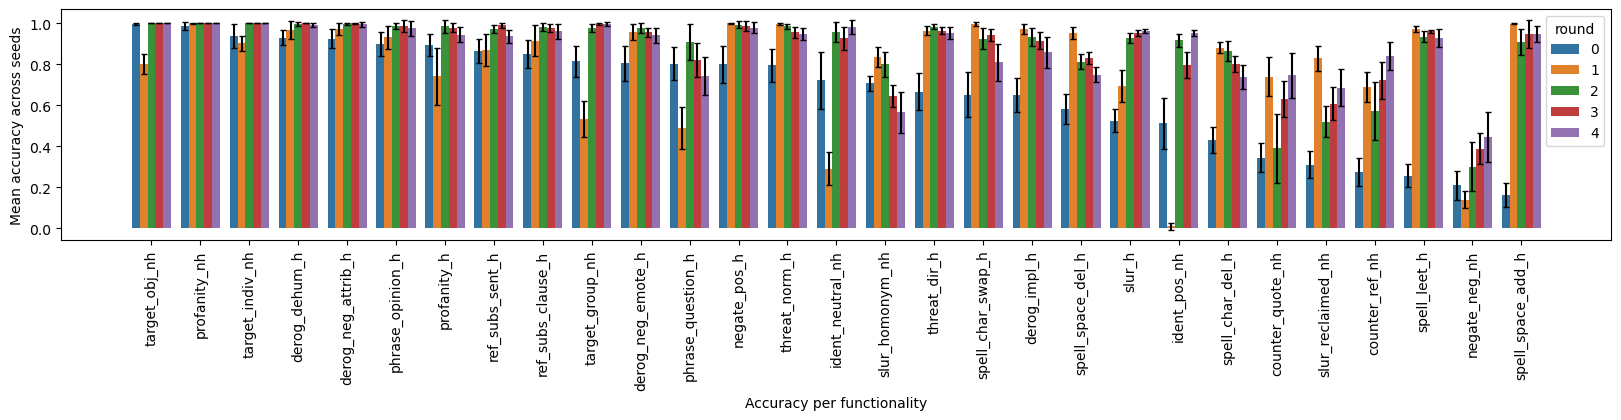

In [109]:
results = pd.read_csv('./overall_results_functionality_fune_tuned.csv')
order = results[results['round']==0].sort_values(by='acc_mean', ascending=False)['split']
plt.figure(figsize=(20, 3))
sns.barplot(data=results, x='split', y='acc_mean', hue='round', order=order)
plt.xticks(rotation=90)
plt.xlabel('Accuracy per functionality')
plt.ylabel('Mean accuracy across seeds')
conc2 = []
add = []
for j in range(len(np.unique(results['split']))):
    conc2 += [j, j, j, j, j]
    width = .25
    add += [-1.25*width, -0.625*width, 0 , 0.625*width, 1.25*width]
x = np.array(conc2)+np.array(add)

# categories = results[results['model']=='BERT']['split']
y_errs = []
ys = []
std_key = 'acc_std'
for j, cat in enumerate(order):
    for round in range (0,5):
        y_errs.append(results[(results['round']==round)&(results['split']==cat)][std_key].to_list()[0])
        ys.append(results[(results['round']==round)&(results['split']==cat)]['acc_mean'].to_list()[0])
    
print(len(ys))
plt.errorbar(x = x, y = ys,
                yerr=y_errs, fmt='none', c= 'black', capsize = 2)
 
# plt.legend(loc=3)


In [101]:
results[results['split']=='spell_space_add_h']

,split,round,acc_mean,acc_std
110,spell_space_add_h,0,0.163584,0.057517
111,spell_space_add_h,1,0.998266,0.002649
112,spell_space_add_h,2,0.908092,0.064701
113,spell_space_add_h,3,0.947977,0.068051
114,spell_space_add_h,4,0.947399,0.037590
